<footer id="footer"></footer>

<p style="align: center;"><img align=center src="https://i.ibb.co/93J4M5N/Pub-Ready-Pub-21015-HPC-Deep-Learning-Resource-Landscape-3-2x-md.jpg" width=500 height=450/></p>

<p align="left"> <a href="https://www.dlschool.org/pro-track">Школа глубокого обучения ФПМИ МФТИ</a></p>

<h4 style="text-align: center;"><b>Полносвязные и свёрточные нейронные сети</b></h4>


---
    
 <font size="1"> Примечание: В этом занятии предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах. </font>












In [ ]:
%%capture
!pip install catalyst

In [ ]:
import numpy as np
import cv2
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tfs
from torch.utils.data import TensorDataset, DataLoader
from catalyst.utils import set_global_seed

import os
from torchvision.datasets import MNIST
from torchsummary import summary
from tqdm import tqdm

sns.set(style="darkgrid")

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

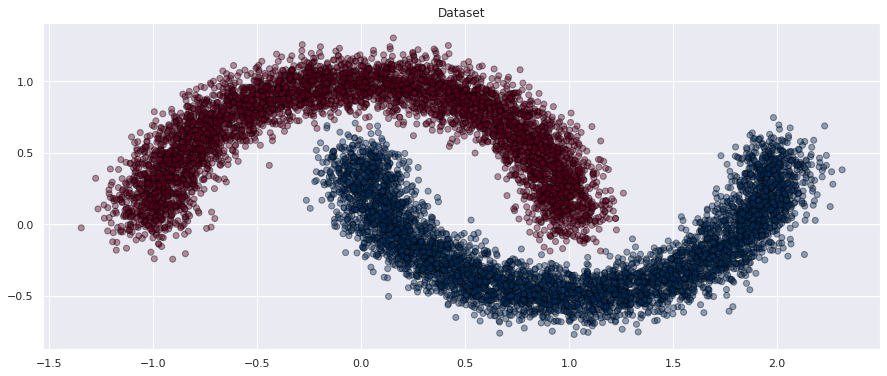

In [ ]:
plt.figure(figsize=(15, 6))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], 
            c=y, 
            cmap="RdBu", 
            alpha=0.42, 
            ec='black'
            )

plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

assert X_train_t.shape[0] == y_train_t.shape[0], 'Проверьте формы выборок'
assert X_val_t.shape[0] == y_val_t.shape[0], 'Проверьте формы выборок'

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Logistic regression is my profession


---
    
 <font size="1"> **Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидою. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$ </font>


### Задание. Реализация логистической регрессии

Необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
dtype = torch.float
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True):

    super().__init__()

    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.weights = nn.Parameter(torch.randn((in_features, out_features), 
                                            requires_grad=True)
    )
    if bias:
      self.bias_term = nn.Parameter(torch.ones(out_features), requires_grad=True)

  def forward(self, x):

    x = x @ self.weights
    if self.bias:
        x += self.bias_term
    return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

#### **Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
params = list(linear_regression.parameters())

print(params)
print('____________________________________________________________')
print(f'В получившейся модели - {len(params)} обучаемых гиперпараметра (-ов) и {len(params) + 1} обучаемых параметра (-ов)')

[Parameter containing:
tensor([[0.4740],
        [0.1978]], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True)]
____________________________________________________________
В получившейся модели - 2 обучаемых гиперпараметра (-ов) и 3 обучаемых параметра (-ов)


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Train loop

Вот псевдокод, который поможет разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        outp = outp.view(-1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 7500
Batch accuracy: 0.734375
Iteration: 15000
Batch accuracy: 0.828125
Iteration: 22500
Batch accuracy: 0.8203125
Iteration: 30000
Batch accuracy: 0.8125
Iteration: 37500
Batch accuracy: 0.8125
Iteration: 45000
Batch accuracy: 0.8125
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.828125

Iteration: 90047.Convergence. Stopping iterations.


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### **Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?


**Ответ:**

In [ ]:
best = 90000
print(f'Потребовалось {best} итераций, чтобы алгоритм сошелся')

Потребовалось 90000 итераций, чтобы алгоритм сошелся


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Визуализируем результаты

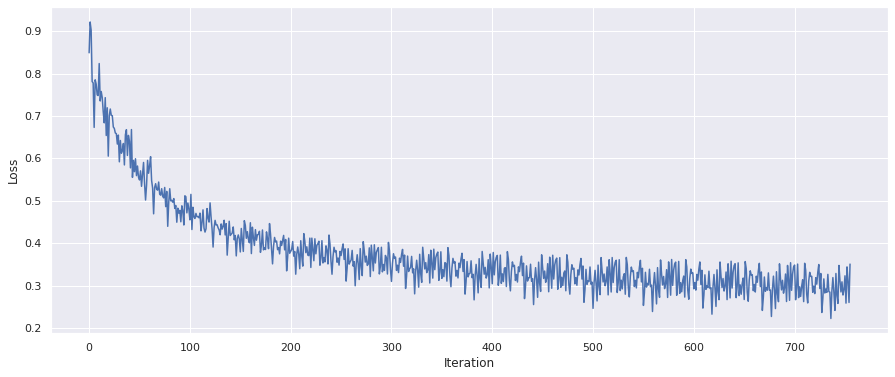

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(losses)), 
         losses, 
         linestyle='-'
         )
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

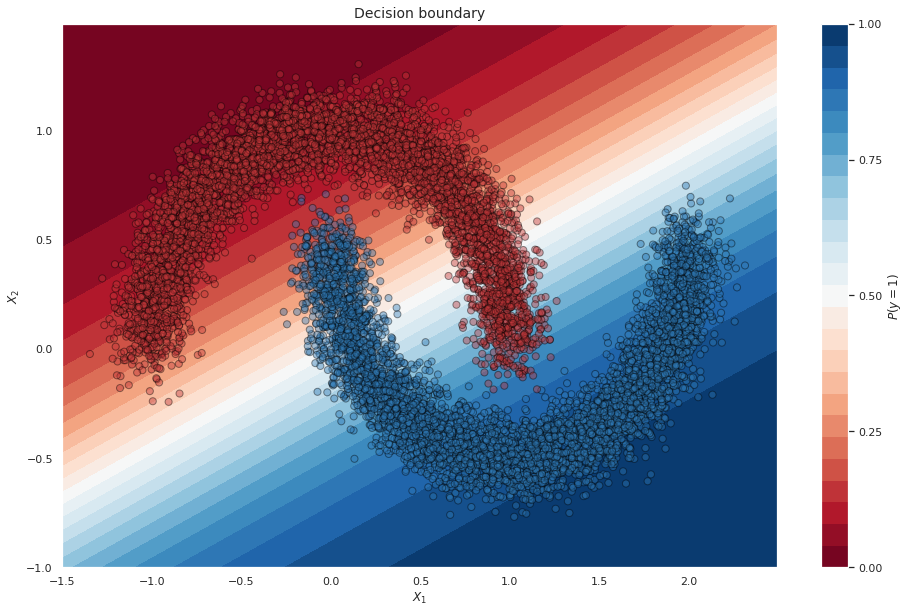

In [ ]:
xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1,
           alpha=0.42, ec='black')

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  linear_regression(x_batch)
        probabilities =  1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
y_val_t.shape

torch.Size([2500])

In [ ]:
y_pred = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val_t, y_pred)

#### **Вопрос 3** Какое `accuracy` получается после обучения?



**Ответ:** 

In [ ]:
print(f'Accuracy после обучения: {accuracy}')

Accuracy после обучения: 0.8664


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
%%capture
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [ ]:
print(f'Data size:\n\t train {len(train_dataset)},\n\t test {len(val_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(val_dataset[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [ ]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


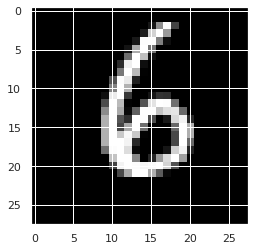

In [ ]:
x_batch, y_batch = next(iter(train_dataloader))
plt.imshow(x_batch[0].numpy().squeeze(), cmap='gray');

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
activation = nn.ELU()


input_size = 784
first_layer = 128
hidden_sizes = [128, 128]
output_size = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, first_layer),
    activation,
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    activation,
    nn.Linear(hidden_sizes[1], output_size),
)

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
!nvidia-smi

Sat Oct 30 15:32:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    60W / 149W |    503MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
summary(model, (input_size,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum(dim=0)
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        acc = round(epoch_correct/epoch_all, 5)
        print(f"Loader: {k}. Accuracy: {acc}")
        accuracy[k].append(acc)

Epoch: 1
Loader: train. Accuracy: 0.89035
Loader: valid. Accuracy: 0.89663
Epoch: 2
Loader: train. Accuracy: 0.95018
Loader: valid. Accuracy: 0.95099
Epoch: 3
Loader: train. Accuracy: 0.96353
Loader: valid. Accuracy: 0.96414
Epoch: 4
Loader: train. Accuracy: 0.9728
Loader: valid. Accuracy: 0.97224
Epoch: 5
Loader: train. Accuracy: 0.9764
Loader: valid. Accuracy: 0.97604
Epoch: 6
Loader: train. Accuracy: 0.9795
Loader: valid. Accuracy: 0.97856
Epoch: 7
Loader: train. Accuracy: 0.98213
Loader: valid. Accuracy: 0.98111
Epoch: 8
Loader: train. Accuracy: 0.984
Loader: valid. Accuracy: 0.98276
Epoch: 9
Loader: train. Accuracy: 0.9857
Loader: valid. Accuracy: 0.98423
Epoch: 10
Loader: train. Accuracy: 0.98663
Loader: valid. Accuracy: 0.98529


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
def test_activation_function(activation):
    print(f'Вычисляю Accuracy для {activation}. Ожидайте...')

    criterion = torch.nn.CrossEntropyLoss()
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    input_size = 784
    first_layer = 128
    hidden_sizes = [128, 128]
    output_size = 10

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, first_layer),
        activation,
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        activation,
        nn.Linear(hidden_sizes[1], output_size),
    )

    optimizer = torch.optim.Adam(model.parameters())

    model.to(device)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        epoch_correct = 0
        epoch_all = 0
        set_global_seed(42 + epoch)
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum(dim=0)
                all =  len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()


            acc = round(epoch_correct/epoch_all, 5)
            accuracy[k].append(acc)

    return accuracy["valid"]

In [ ]:
elu_accuracy = accuracy["valid"]
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.1))

Вычисляю Accuracy для Identical(). Ожидайте...
Вычисляю Accuracy для ReLU(). Ожидайте...
Вычисляю Accuracy для LeakyReLU(negative_slope=0.1). Ожидайте...


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

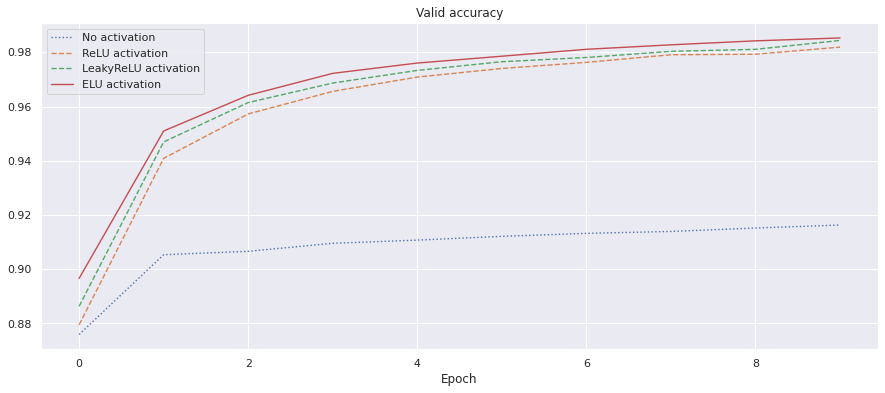

In [ ]:
sns.set(style="darkgrid")
max_epochs=10
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), 
         plain_accuracy, 
         label="No activation", 
         linewidth=1.4,
         linestyle='dotted'
         )
plt.plot(range(max_epochs), 
         relu_accuracy, 
         label="ReLU activation", 
         linewidth=1.4,
         linestyle='dashed'
         )
plt.plot(range(max_epochs), 
         leaky_relu_accuracy, 
         label="LeakyReLU activation", 
         linewidth=1.4,
         linestyle='--'
         )
plt.plot(range(max_epochs), 
         elu_accuracy, 
         label="ELU activation", 
         linewidth=1.4,
         linestyle='solid'
         )
plt.legend()
plt.xlabel("Epoch")
plt.show()

#### **Вопрос 4** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [ ]:
the_best = nn.ELU()
print(f'Наивысший accuracy к концу обучения показала {the_best}')

Наивысший accuracy к концу обучения показала ELU(alpha=1.0)


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
%%capture
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

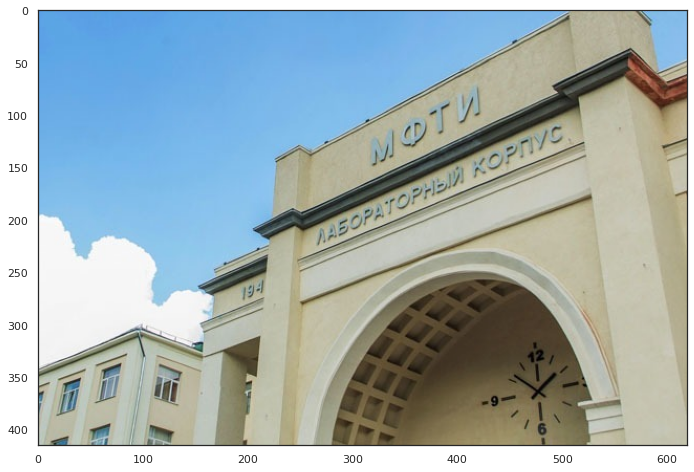

In [ ]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Посмотрим как различные свертки влияют на фото. Например,
 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```



In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


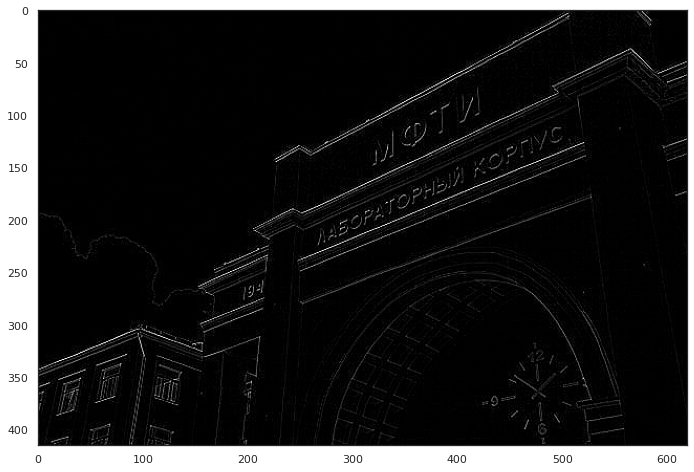

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

#### **Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

In [ ]:
quest = [1, 2, 3, 4, 5, 6]
var = ['Е', 'Д', 'А', 'Б', 'В', 'Г']
print(f'{quest[0]}: {var[0]}, {quest[1]}: {var[1]}, '
      f'{quest[2]}: {var[2]}, {quest[3]}: {var[3]}, '
      f'{quest[4]}: {var[4]}, {quest[5]}: {var[5]}')

1: Е, 2: Д, 3: А, 4: Б, 5: В, 6: Г


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 input image channel, 6 output channels, 3x3 square conv kernel

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Задание. Обучите CNN
Используем код обучения, который мы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum(dim=0)
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        acc = round(epoch_correct/epoch_all, 5)
        print(f"Loader: {k}. Accuracy: {acc}")
        accuracy[k].append(acc)

Epoch: 1
Loader: train. Accuracy: 0.90198
Loader: valid. Accuracy: 0.91209
Epoch: 2
Loader: train. Accuracy: 0.97297
Loader: valid. Accuracy: 0.97393
Epoch: 3
Loader: train. Accuracy: 0.97973
Loader: valid. Accuracy: 0.98056
Epoch: 4
Loader: train. Accuracy: 0.98428
Loader: valid. Accuracy: 0.9845
Epoch: 5
Loader: train. Accuracy: 0.9877
Loader: valid. Accuracy: 0.98744
Epoch: 6
Loader: train. Accuracy: 0.98938
Loader: valid. Accuracy: 0.98897
Epoch: 7
Loader: train. Accuracy: 0.99107
Loader: valid. Accuracy: 0.99056
Epoch: 8
Loader: train. Accuracy: 0.99242
Loader: valid. Accuracy: 0.99149
Epoch: 9
Loader: train. Accuracy: 0.99333
Loader: valid. Accuracy: 0.99271
Epoch: 10
Loader: train. Accuracy: 0.9946
Loader: valid. Accuracy: 0.99389


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

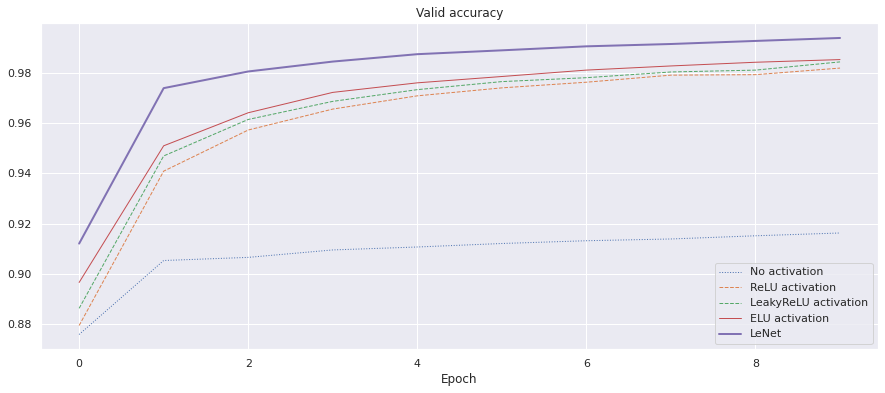

In [ ]:
sns.set(style="darkgrid")
max_epochs=10
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), 
         plain_accuracy, 
         label="No activation", 
         linewidth=1,
         linestyle='dotted'
         )
plt.plot(range(max_epochs), 
         relu_accuracy, 
         label="ReLU activation", 
         linewidth=1,
         linestyle='dashed'
         )
plt.plot(range(max_epochs), 
         leaky_relu_accuracy, 
         label="LeakyReLU activation", 
         linewidth=1,
         linestyle='--'
         )
plt.plot(range(max_epochs), 
         elu_accuracy, 
         label="ELU activation", 
         linewidth=1,
         linestyle='solid'
         )
plt.plot(range(max_epochs), 
         lenet_accuracy, 
         label="LeNet", 
         linewidth=2,
         linestyle='solid'
         )
plt.legend()
plt.xlabel("Epoch")
plt.show()

#### **Вопрос 6** Какое `accuracy` получается после обучения 
 <font size="1">С точностью до двух знаков после запятой </font>


**Ответ:**

In [ ]:
acc = round(max(lenet_accuracy), 2)
print(f'LeNet Accuracy послу обучения составляет {acc}')

LeNet Accuracy послу обучения составляет 0.99


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___